Readme

This cell is just a helper to ensure the required Python libraries for this Notebook are installed in your Conda environment.

In [2]:
import sys
%conda install --yes --prefix {sys.prefix} -r requirements.txt

# This will reload the kernel with your new packages present, you may wish to run this yourself
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: -r

Note: you may need to restart the kernel to use updated packages.


This cell generates some fake sales data for a few stores in different timezones
It also stores the computed opening hours for each store so you can easily track DST changes against transaction times
Feel free to modify the included stores and timezones, though note that London is the specific DST change example we use in this notebook

In [73]:
import random
import pytz
from datetime import datetime, timedelta

# Define store locations and timezones
stores = [
    {'name': 'New York', 'timezone': 'America/New_York'},
    {'name': 'London', 'timezone': 'Europe/London'},
    {'name': 'Madrid', 'timezone': 'Europe/Madrid'},
    {'name': 'Tokyo', 'timezone': 'Asia/Tokyo'},
]

# Define start and end dates
start_date = datetime(2023, 3, 20)
end_date = datetime(2023, 4, 4)

# Define the mean and standard deviation for sales amounts
min_sale_amount = 15
mean_sale_amount = 100
std_sale_amount = 50
max_sale_amount = 250

# 
mean_sales_count = 150
std_sales_count = 25

# Define the number of hours each store is open
store_hours_open = 8
# Generate sales data for each store
sales_data = []
store_hours_data = []
for store in stores:
    store_sales = []
    store_hours = []
    store_timezone = pytz.timezone(store['timezone'])
    store_date = start_date

    while store_date <= end_date:
        # Define the store's open and close time
        # We need to do this with each calendar day as the daylight savings time may change on any given day
        start_time_local = store_timezone.localize(store_date).replace(hour=9, minute=0, second=0, microsecond=0)
        end_time_local = store_timezone.localize(store_date).replace(hour=9+store_hours_open, minute=0, second=0, microsecond=0)
        

        # write the store hours to the store_hours_data
        store_hours.append({
            'store': store['name'],
            'timezone': store['timezone'],
            'store_date': store_date.date().isoformat(),
            'store_hours_open': store_hours_open,
            'store_timezone_offset': store_timezone.utcoffset(store_date).total_seconds(),
            'store_open_time_local': start_time_local.isoformat(),
            'store_close_time_local': end_time_local.isoformat(),
            'store_open_time_utc': start_time_local.astimezone(pytz.utc).isoformat(),
            'store_close_time_utc': end_time_local.astimezone(pytz.utc).isoformat(),
        })

        # Generate a random number of sales for the day based on a normal distribution
       
        sales_count = int(random.normalvariate(mean_sales_count, std_sales_count))

        # Generate sales randomly across the day
        sale_times_seconds = [random.randint(1, store_hours_open * 60 * 60) for i in range(sales_count)]

        # Convert seconds into sale times
        sale_times_local = [start_time_local + timedelta(seconds=s) for s in sale_times_seconds]

        # Generate sales for each sale time
        for sale_time_local in sale_times_local:
            # Generate a random sale amount between $15 and $250 based on a normal distribution
            sale_amount = round(random.normalvariate(mean_sale_amount, std_sale_amount), 2)
            sale_amount = max(min_sale_amount, min(max_sale_amount, sale_amount))

            # Convert the sale time from the store's local timezone to UTC
            # This simulates a typical data pattern where the sale time is generated in a local timezone but stored in UTC for analysis
            sale_time_utc = sale_time_local.astimezone(pytz.utc)

            # Add the sale to the store's sales data
            store_sales.append({
                'store': store['name'],
                'timezone': store['timezone'],
                'timestamp_local': sale_time_local.isoformat(),
                'timestamp_utc': sale_time_utc.isoformat(),
                'sale_amount': sale_amount
            })

        # Increment the store's time by 1 day
        store_date += timedelta(days=1)

    # Add the store's sales data to the overall sales data
    sales_data.extend(store_sales)
    # Add the store's hours data to the overall hours data
    store_hours_data.extend(store_hours)


Here we pull both our new sample datasets into DataFrames and grab a quick sample to eyeball if the columns and values look correct.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the sales data to a pandas dataframe
df = pd.DataFrame(sales_data)

# Set the timestamp_utc column as the index of the dataframe
df = df.set_index('timestamp_utc')

# Convert the index to a DatetimeIndex
df.index = pd.to_datetime(df.index)

df.sample()

,store,timezone,timestamp_local,sale_amount
timestamp_utc,,,,
2023-04-03 18:36:04+00:00,New York,America/New_York,2023-04-03T14:36:04-04:00,171.21


In [75]:
dt = pd.DataFrame(store_hours_data)
dt.sample()

,store,timezone,store_date,store_hours_open,store_timezone_offset,store_open_time_local,store_close_time_local,store_open_time_utc,store_close_time_utc
23,London,Europe/London,2023-03-27,8,3600.0,2023-03-27T09:00:00+01:00,2023-03-27T17:00:00+01:00,2023-03-27T08:00:00+00:00,2023-03-27T16:00:00+00:00


Now let's plot out each store to check the rough periodicity of the data.
We should see clear peaks as each store is only open for 8 out of 24 hours.
We should see that none of the periods directly overlap which shows they are correctly mapped to their local timezone.
Each line in the plot should start and end in slightly different places on the x axis to represent their local timezone offset against UTC.

Overall it is a very busy graph, so we'll dive into an individual store next to validate our generator is working as expected.

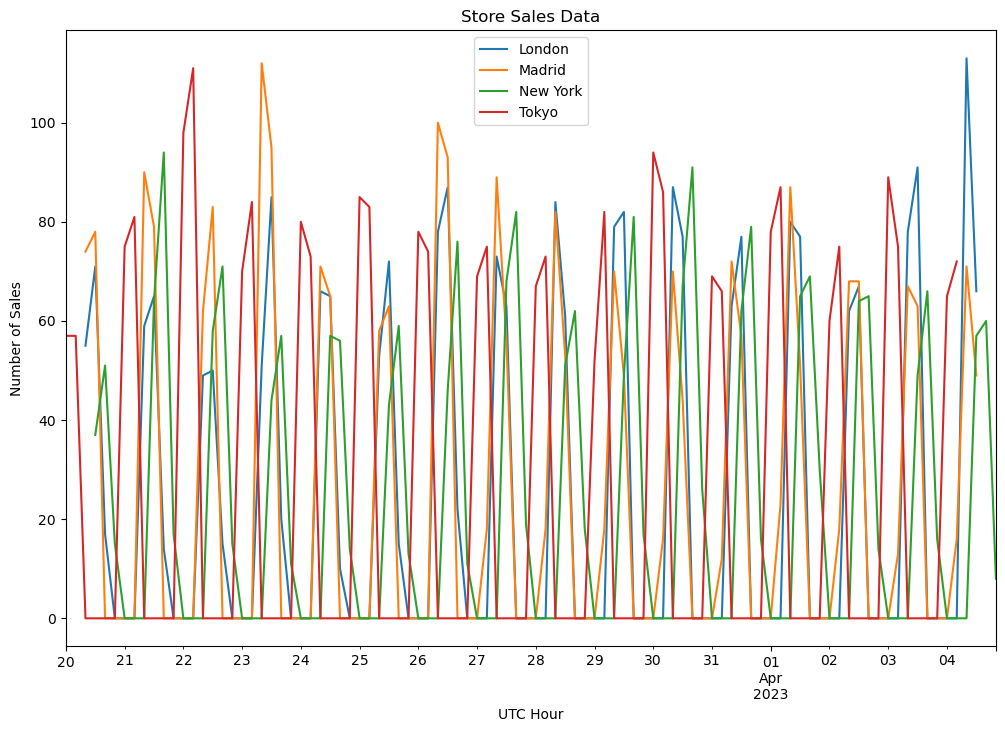

In [76]:
# Resample the sales data to hourly intervals
hourly_sales_4 = df.groupby('store').resample('4H').size().unstack(level=0)

# Plot the number of sales per hour for each store as a line chart
plt.figure(figsize=(12, 8))  # Set the size of the plot
for store in hourly_sales_4.columns:
    hourly_sales_4[store].plot(label=store)

# Format the plot
plt.xlabel('UTC Hour')
plt.ylabel('Number of Sales')
plt.title('Store Sales Data')
plt.legend()
plt.show()


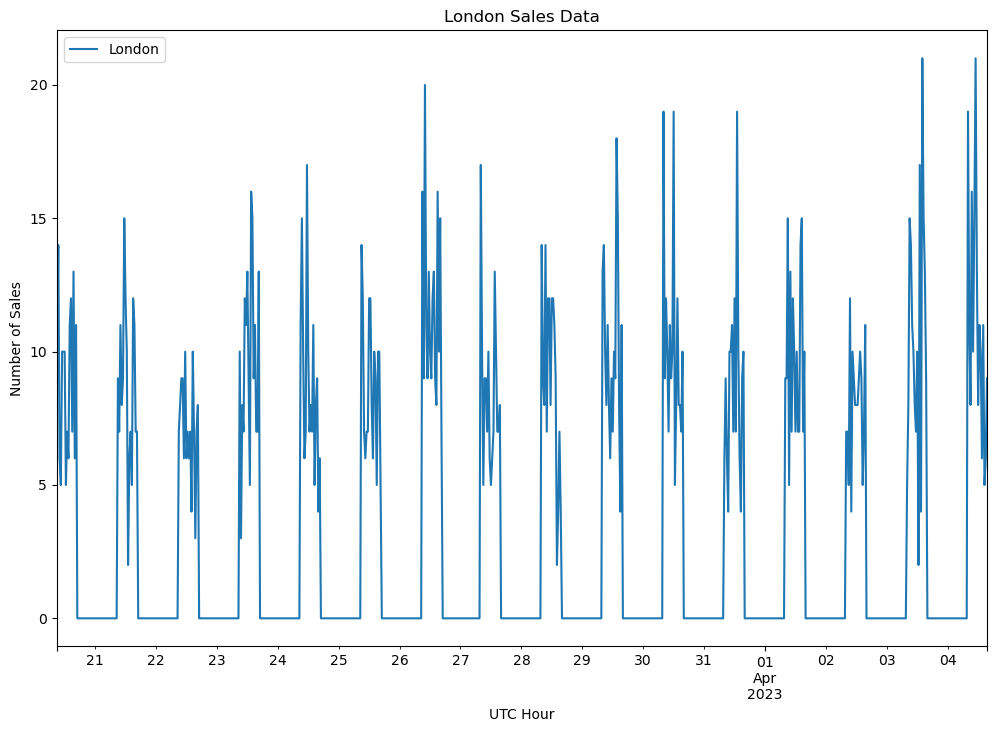

In [77]:
# Choose a single store to plot
store_name = 'London'

# Filter the sales data for the chosen store
london_store_sales = df[df['store'] == store_name]

# Resample the sales data to half hourly intervals
hourly_sales_30 = london_store_sales.resample('30Min').size()

# Plot the number of sales per hour for the chosen store as a line chart
plt.figure(figsize=(12, 8))
hourly_sales_30.plot(label=store_name)

# Format the plot
plt.xlabel('UTC Hour')
plt.ylabel('Number of Sales')
plt.title(f'{store_name} Sales Data')
plt.legend()
plt.show()


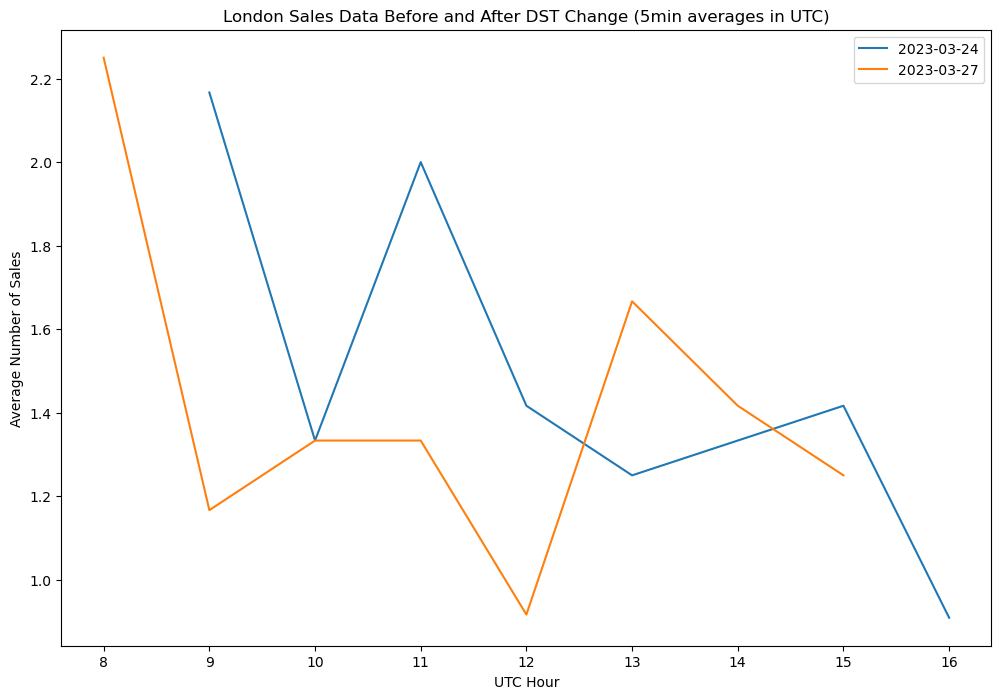

In [78]:
# Choose the days before and after the DST change
day_before_dst = '2023-03-24'
day_after_dst = '2023-03-27'

# Filter the sales data for the chosen days
day_before_sales = london_store_sales[(london_store_sales.index.date == pd.to_datetime(day_before_dst).date())]
day_after_sales = london_store_sales[(london_store_sales.index.date == pd.to_datetime(day_after_dst).date())]

# Resample the sales data to hourly intervals
sales_before_5m = day_before_sales.resample('5Min').size()
sales_after_5m = day_after_sales.resample('5Min').size()

# Calculate the mean sales per hour across the selected period
mean_sales_before = sales_before_5m.groupby(sales_before_5m.index.hour).mean()
mean_sales_after = sales_after_5m.groupby(sales_after_5m.index.hour).mean()

# Plot the normalized number of sales per hour for the chosen store and days as a line chart
plt.figure(figsize=(12, 8))
mean_sales_before.plot(label=day_before_dst)
mean_sales_after.plot(label=day_after_dst)

# Format the plot
plt.xlabel('UTC Hour')
plt.ylabel('Average Number of Sales')
plt.title(f'London Sales Data Before and After DST Change (5min averages in UTC)')
plt.legend()
plt.show()


Now let's do a specific check on our DST change.
We have a high number of randomly generated sales throughout the business day, so we should expect to see a sale reasonably soon after the store opens each day, and just before closing.
Taking the day before the DST change, and the day after the DST change, and examining the UTC timestamps of these events relative to each other, we should see that there is almost exactly a 1hr offset for the London store's sales.

In [79]:
opening_time_before = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_before_dst][0]['store_open_time_utc']
first_sale_utc_before = day_before_sales.index.min()
last_sale_utc_before = day_before_sales.index.max()
closing_time_before = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_before_dst][0]['store_close_time_utc']

opening_time_after = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_after_dst][0]['store_open_time_utc']
first_sale_utc_after = day_after_sales.index.min()
last_sale_utc_after = day_after_sales.index.max()
closing_time_after = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_after_dst][0]['store_close_time_utc']


print(f"London opening time on March 24th (UTC): {opening_time_before}")
print(f"Time of first sale in London on March 24th (UTC): {first_sale_utc_before}")
print(f"Time of last sale in London on March 24th (UTC): {last_sale_utc_before}")
print(f"London closing time on March 24th (UTC): {closing_time_before}")
print("\n")
print(f"London opening time on March 27th (UTC): {opening_time_after}")
print(f"Time of first sale in London on March 27th (UTC): {first_sale_utc_after}")
print(f"Time of last sale in London on March 27th (UTC): {last_sale_utc_after}")
print(f"London closing time on March 27th (UTC): {closing_time_after}")

London opening time on March 24th (UTC): 2023-03-24T09:00:00+00:00
Time of first sale in London on March 24th (UTC): 2023-03-24 09:00:05+00:00
Time of last sale in London on March 24th (UTC): 2023-03-24 16:54:08+00:00
London closing time on March 24th (UTC): 2023-03-24T17:00:00+00:00


London opening time on March 27th (UTC): 2023-03-27T08:00:00+00:00
Time of first sale in London on March 27th (UTC): 2023-03-27 08:03:07+00:00
Time of last sale in London on March 27th (UTC): 2023-03-27 15:55:20+00:00
London closing time on March 27th (UTC): 2023-03-27T16:00:00+00:00


Finally, satisfied that our data is representative of the situation we are examining, we output it as ndjson ready for import to Tinybird!

In [81]:
import json

# Open the output file
with open('sales_data.ndjson', 'w') as f:
    # Write each sale as a JSON object on a new line
    for sale in sales_data:
        f.write(json.dumps(sale) + '\n')